# Imports and device management

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from PIL import Image
import shutil
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import copy
!pip3 install umap-learn
!pip3 install umap-learn[plot]
import umap
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import re

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=bf25cda18f0dae9316a8fcd5d69bd826e7d3475bf6d95d0f1f28e09c4feb1841
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Load data

## Modify the .csv file

In [3]:
# Define base paths (Google Colab paths)
base_path = '/content/drive/MyDrive/cerviscreen'
meta_path = os.path.join(base_path, 'Cases_Meta_data.csv')
images_csv_path = os.path.join(base_path, 'Cases_Images.csv')

# Read metadata CSV
df_meta = pd.read_csv(meta_path)
if 'Case Number' not in df_meta.columns:
    df_meta = pd.read_csv(meta_path, header=1)

# Read images CSV
df_imgs = pd.read_csv(images_csv_path)
if 'Case Number' not in df_imgs.columns:
    df_imgs = pd.read_csv(images_csv_path, header=1)

# Clean column names (strip whitespace/newlines)
df_meta.columns = [str(c).replace('\n', ' ').strip() for c in df_meta.columns]
df_imgs.columns = [str(c).replace('\n', ' ').strip() for c in df_imgs.columns]

print("Metadata columns:", df_meta.columns.tolist())
print("Images columns:", df_imgs.columns.tolist())

# Locate the type column to filter out problematic entries
type_col = next((c for c in df_imgs.columns if 'type' in c.lower()), None)
if type_col is None:
    raise KeyError(f"Couldn't find a 'type' column. Columns seen: {list(df_imgs.columns)}")

# Locate the provisional diagnosis column
diag_col = next((c for c in df_meta.columns
                 if 'provisional' in c.lower() and 'diagnos' in c.lower()), None)
if diag_col is None:
    raise KeyError(f"Couldn't find a provisional diagnosis column. Columns seen: {list(df_meta.columns)}")

# Locate case number and file columns
case_col_meta = 'Case Number' if 'Case Number' in df_meta.columns else next((c for c in df_meta.columns if 'case' in c.lower() and 'number' in c.lower()), None)
case_col_imgs = 'Case Number' if 'Case Number' in df_imgs.columns else next((c for c in df_imgs.columns if 'case' in c.lower() and 'number' in c.lower()), None)
file_col = 'File' if 'File' in df_imgs.columns else next((c for c in df_imgs.columns if 'file' in c.lower() or 'filename' in c.lower()), None)

if case_col_meta is None or case_col_imgs is None or file_col is None:
    raise KeyError(f"Couldn't find required columns in metadata or images CSV")

# Keep only case number and diagnosis from metadata
df_meta_clean = df_meta[[case_col_meta, diag_col]].copy()
df_meta_clean.columns = ['Case Number', 'Provisional Diagnosis']

# Keep only case number, file, and type from images
df_imgs_clean = df_imgs[[case_col_imgs, file_col, type_col]].copy()
df_imgs_clean.columns = ['Case Number', 'File', 'Type']

# Join metadata and images on case number
df_merged = pd.merge(df_imgs_clean, df_meta_clean, on='Case Number', how='inner')

print(f"\nMerged {len(df_merged)} image records with metadata")

# Remove rows where Type contains 'green', 'speculum', or 'iodine' (case-insensitive)
remove_pattern = re.compile(r'\b(green|speculum|iodine)\b', flags=re.IGNORECASE)
keep_mask = ~df_merged['Type'].astype(str).apply(lambda s: bool(remove_pattern.search(s)))
df_filtered = df_merged[keep_mask].copy()

print(f"After filtering (removed green/speculum/iodine from Type): {len(df_filtered)} records")

# Convert to binary diagnosis
def to_binary_diag(x):
    if isinstance(x, str) and re.search(r'\bnormal\b', x, flags=re.IGNORECASE):
        return 'normal'
    return 'abnormal'

df_filtered['Provisional Diagnosis'] = df_filtered['Provisional Diagnosis'].apply(to_binary_diag)

# Keep only file and provisional diagnosis
df_filtered = df_filtered[['File', 'Provisional Diagnosis']].copy()

# Save filtered CSV for reference
filtered_csv_path = os.path.join(base_path, 'Cases_filtered.csv')
df_filtered.to_csv(filtered_csv_path, index=False)

print(f'Saved filtered CSV: {filtered_csv_path}')
print(f'\nDiagnosis distribution:')
print(df_filtered['Provisional Diagnosis'].value_counts())
print(f'\nFirst few rows:')
print(df_filtered.head())

# Prepare data for splitting
X = df_filtered[['File']].values
y = df_filtered[['Provisional Diagnosis']].values

Metadata columns: ['Case Number', 'CaseID', 'HPV', 'Adequacy', 'Reason', 'Squamocolumnar junction visibility', 'Transformation zone', 'Original squamous epithelium', 'Columnar epithelium', 'Metaplastic squamous epithelium', 'Deciduosis in pregnancy', 'Location of the lesion', 'Location of the lesion by clock position', 'additional position 1', 'additional position 2', 'additional position 3', 'No of quadrants', '% of cervix', 'Grade 1', 'additional Grade 1', 'additional Grade 1.1', 'additional Grade 1.2', 'Grade 2', 'additional Grade 2', 'additional Grade 2.1', 'additional Grade 2.2', 'additional Grade 2.3', 'Non-specific', 'additional Non-specific', 'Suspicious for invasion', 'additional Suspicious for invasion', 'additional Suspicious for invasion.1', 'Miscellaneous finding', 'Additional miscellaneous finding', 'Aceto uptake', 'Margins', 'Vessels', 'Lesion size', 'Iodine uptake', 'SwedeFinal', 'Provisional diagnosis', 'Management', 'Histopathology']
Images columns: ['Case Number', 'F

## Filter images

In [4]:
# --- Copy filtered images to a single directory based on filenames in the filtered CSV ---

base_path = '/content/drive/MyDrive/cerviscreen'
output_dir = os.path.join(base_path, 'Filtered_Images')

# Use the filtered CSV from the previous cell
filtered_filenames = set(df_filtered['File'].str.strip().values)

print(f'Looking for {len(filtered_filenames)} images from the filtered CSV...')

os.makedirs(output_dir, exist_ok=True)

copied, missing = 0, 0
missing_files = []

# Iterate through all case folders to find and copy matching images
for case_num in range(1, 201):  # Assuming cases are numbered 1-200
    case_folder = f"Case {case_num:03d}"
    case_path = os.path.join(base_path, case_folder)

    if not os.path.isdir(case_path):
        continue

    # Check all files in the case folder
    for filename in os.listdir(case_path):
        if filename in filtered_filenames:
            src_path = os.path.join(case_path, filename)
            out_path = os.path.join(output_dir, filename)
            shutil.copy2(src_path, out_path)
            copied += 1

# Check for files in filtered CSV that weren't found
found_filenames = set(os.listdir(output_dir))

for filename in filtered_filenames:
    if filename not in found_filenames:
        missing += 1
        missing_files.append(filename)

print(f"Copied images: {copied} to {output_dir}")
print(f"Missing images: {missing}")

if missing_files:
    print(f"\nMissing files (first 10):")
    for f in missing_files[:10]:
        print(f"  {f}")

Looking for 494 images from the filtered CSV...
Copied images: 492 to /content/drive/MyDrive/cerviscreen/Filtered_Images
Missing images: 2

Missing files (first 10):
  AAFW3.jpg
  AAFW0.jpg


## Split .csv file into train, val, test

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# First, split into train+val and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_val_index, test_index = next(sss.split(X, y))
X_train_val, X_test = X[train_val_index], X[test_index]
y_train_val, y_test = y[train_val_index], y[test_index]

# Then, split train+val into train and validation sets
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_index, val_index = next(sss_val.split(X_train_val, y_train_val))
X_train, X_val = X_train_val[train_index], X_train_val[val_index]
y_train, y_val = y_train_val[train_index], y_train_val[val_index]

# Print the distribution of classes in each split
for name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    unique, counts = np.unique(y_split, return_counts=True)
    print(f"{name} set distribution:")
    for class_label, count in zip(unique, counts):
        print(f"  Class {class_label}: {count} ({count/len(y_split):.2%})")
    print()


Train set distribution:
  Class abnormal: 187 (63.18%)
  Class normal: 109 (36.82%)

Validation set distribution:
  Class abnormal: 62 (62.63%)
  Class normal: 37 (37.37%)

Test set distribution:
  Class abnormal: 62 (62.63%)
  Class normal: 37 (37.37%)



In [6]:
column_names = df_filtered.columns.tolist()

train_df = pd.DataFrame(np.concatenate((X_train, y_train), axis=1), columns=column_names)
val_df = pd.DataFrame(np.concatenate((X_val, y_val), axis=1), columns=column_names)
test_df = pd.DataFrame(np.concatenate((X_test, y_test), axis=1), columns=column_names)

base_path = '/content/drive/MyDrive/cerviscreen'
train_csv_path = os.path.join(base_path, 'train.csv')
val_csv_path = os.path.join(base_path, 'val.csv')
test_csv_path = os.path.join(base_path, 'test.csv')

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f'Saved: {train_csv_path}')
print(f'Saved: {val_csv_path}')
print(f'Saved: {test_csv_path}')

Saved: /content/drive/MyDrive/cerviscreen/train.csv
Saved: /content/drive/MyDrive/cerviscreen/val.csv
Saved: /content/drive/MyDrive/cerviscreen/test.csv


## Move images into train, val, test subfolders

In [7]:
base_path = '/content/drive/MyDrive/cerviscreen'
images_directory = os.path.join(base_path, 'Filtered_Images')

train_directory = os.path.join(base_path, 'train_images')
val_directory = os.path.join(base_path, 'val_images')
test_directory = os.path.join(base_path, 'test_images')

for directory in [train_directory, val_directory, test_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to copy images based on DataFrame; missing files are dropped from the CSVs
def copy_images(dataframe, target_directory):
    "Copy images from Filtered_Images to target split directory; drop missing files"
    kept_files = []
    kept_labels = []
    missing_files = []

    for _, row in dataframe.iterrows():
        image_name = row['File']
        image_path = os.path.join(images_directory, image_name)

        if os.path.exists(image_path):
            dest_path = os.path.join(target_directory, image_name)
            shutil.copy2(image_path, dest_path)
            kept_files.append(image_name)
            kept_labels.append(row['Provisional Diagnosis'])
        else:
            missing_files.append(image_name)

    if missing_files:
        print(f"Missing in {images_directory} (dropped from CSV): {missing_files}")

    return pd.DataFrame({
        'File': kept_files,
        'Provisional Diagnosis': kept_labels
    })

# Copy the images according to the splits and update dataframes
train_df = copy_images(train_df, train_directory)
val_df = copy_images(val_df, val_directory)
test_df = copy_images(test_df, test_directory)

# Re-save the CSV files with updated filenames
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train images copied: {len(os.listdir(train_directory))} to {train_directory}")
print(f"Val images copied: {len(os.listdir(val_directory))} to {val_directory}")
print(f"Test images copied: {len(os.listdir(test_directory))} to {test_directory}")
print("CSV files updated with correct filenames")



Missing in /content/drive/MyDrive/cerviscreen/Filtered_Images (dropped from CSV): ['AAFW3.jpg']
Missing in /content/drive/MyDrive/cerviscreen/Filtered_Images (dropped from CSV): ['AAFW0.jpg']
Train images copied: 296 to /content/drive/MyDrive/cerviscreen/train_images
Val images copied: 98 to /content/drive/MyDrive/cerviscreen/val_images
Test images copied: 98 to /content/drive/MyDrive/cerviscreen/test_images
CSV files updated with correct filenames


## Image augmentation

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## Datasets and Dataloaders

In [9]:
class CervicalImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        label = self.data_frame.iloc[idx, 1]

        # Convert label to binary (0 for normal, 1 for abnormal)
        label = 0 if label == 'normal' else 1

        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define dataset paths (Google Colab paths)
base_path = '/content/drive/MyDrive/cerviscreen'
csv_files = {
    'train': os.path.join(base_path, 'train.csv'),
    'val': os.path.join(base_path, 'val.csv'),
    'test': os.path.join(base_path, 'test.csv')
}

# Define directories
data_dirs = {
    'train': os.path.join(base_path, 'train_images'),
    'val': os.path.join(base_path, 'val_images'),
    'test': os.path.join(base_path, 'test_images')
}

# Create datasets
image_datasets = {x: CervicalImageDataset(csv_file=csv_files[x],
                                        root_dir=data_dirs[x],
                                        transform=data_transforms[x])
               for x in ['train', 'val', 'test']}

# Create DataLoaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True if x == 'train' else False, num_workers=0)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

print("Dataset sizes:")
for split in ['train', 'val', 'test']:
    print(f"  {split}: {dataset_sizes[split]}")

Dataset sizes:
  train: 296
  val: 98
  test: 98


## Visualise images

## Before and after masking and transform

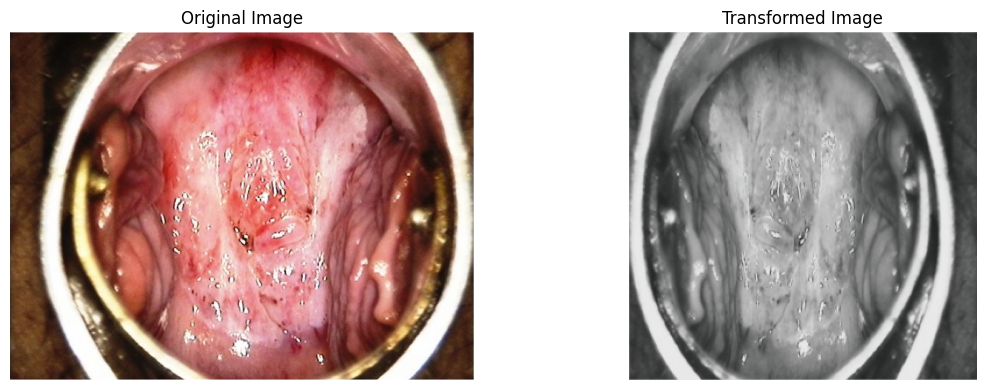

In [10]:
# Instantiate the dataset object
base_path = '/content/drive/MyDrive/cerviscreen'
train_csv = os.path.join(base_path, 'train.csv')
train_dir = os.path.join(base_path, 'train_images')

dataset = CervicalImageDataset(csv_file=train_csv, root_dir=train_dir)

# Load and display the first image in the training set
df_train = pd.read_csv(train_csv)
img_name = os.path.join(train_dir, df_train.iloc[0, 0])

if os.path.exists(img_name):
    image = Image.open(img_name).convert('RGB')
    image_np = np.array(image)

    # Display the original image
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    # Apply the transformation and display the transformed image
    transformed_image = data_transforms['train'](image)
    transformed_image_np = transformed_image.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    transformed_image_np = (transformed_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255  # Denormalize
    transformed_image_np = np.clip(transformed_image_np, 0, 255).astype(np.uint8)  # Clip values and convert to uint8

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image_np)
    plt.title('Transformed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Image not found: {img_name}")

# Train the model

## Modifying last fully connected layer

In [11]:
class CustomResnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResnet50, self).__init__()
        self.resnet = models.resnet50(weights="IMAGENET1K_V2")
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        # Higher dropout to reduce overfitting
        self.shared_layers = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.shared_layers(x)
        output = self.fc_out(x)
        return output

# Initialize the model
model = CustomResnet50(num_classes=2)
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights from TRAIN only to avoid leakage
train_csv_path = os.path.join(base_path, 'train.csv')
train_df = pd.read_csv(train_csv_path)
train_labels = (train_df['Provisional Diagnosis'] == 'abnormal').astype(int).values

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights (Normal, Abnormal): {class_weights.tolist()}")

# Criterion definition with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)



Class weights (Normal, Abnormal): [1.3577982187271118, 0.7914438247680664]


## Training loop

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

# Training and evaluation functions
def train_model(model, dataloaders, criterion, num_epochs=30, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    train_loss_history, val_loss_history = [], []
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train(phase == 'train')
            running_loss, correct = 0.0, 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = correct.double() / total_samples

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                print(f'Train Loss: {epoch_loss:.4f}')
                print(f'Train Accuracy: {epoch_acc:.4f}')
            else:
                val_loss_history.append(epoch_loss)
                print(f'Val Loss: {epoch_loss:.4f}')
                print(f'Val Accuracy: {epoch_acc:.4f}')

                # Early stopping logic
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print('Early stopping triggered')
                        model.load_state_dict(best_model_wts)
                        return model, train_loss_history, val_loss_history

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history



## Model evaluation

In [14]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            preds = torch.argmax(output, dim=1)

            correct += torch.sum(preds == labels)
            total_samples += inputs.size(0)

    accuracy = correct.double() / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

## Run

In [15]:
num_epochs = 30
patience = 10
model, train_loss_history, val_loss_history = train_model(model, dataloaders, criterion, num_epochs=num_epochs, patience=patience)
torch.save(model.state_dict(), '/content/drive/MyDrive/cerviscreen/resnet50_finetuned.pth')

Epoch 0/29
----------
Train Loss: 0.6937
Train Accuracy: 0.6149
Val Loss: 0.6933
Val Accuracy: 0.6327
Epoch 1/29
----------
Train Loss: 0.6915
Train Accuracy: 0.6318
Val Loss: 0.6927
Val Accuracy: 0.6327
Epoch 2/29
----------
Train Loss: 0.6907
Train Accuracy: 0.6419
Val Loss: 0.6913
Val Accuracy: 0.6327
Epoch 3/29
----------
Train Loss: 0.6878
Train Accuracy: 0.6453
Val Loss: 0.6890
Val Accuracy: 0.6327
Epoch 4/29
----------
Train Loss: 0.6839
Train Accuracy: 0.6520
Val Loss: 0.6886
Val Accuracy: 0.6327
Epoch 5/29
----------
Train Loss: 0.6833
Train Accuracy: 0.6926
Val Loss: 0.6885
Val Accuracy: 0.6429
Epoch 6/29
----------
Train Loss: 0.6794
Train Accuracy: 0.6892
Val Loss: 0.6855
Val Accuracy: 0.6429
Epoch 7/29
----------
Train Loss: 0.6780
Train Accuracy: 0.6824
Val Loss: 0.6829
Val Accuracy: 0.6429
Epoch 8/29
----------
Train Loss: 0.6688
Train Accuracy: 0.7061
Val Loss: 0.6794
Val Accuracy: 0.6735
Epoch 9/29
----------
Train Loss: 0.6633
Train Accuracy: 0.6858
Val Loss: 0.6750
V

## Plot loss vs epoch

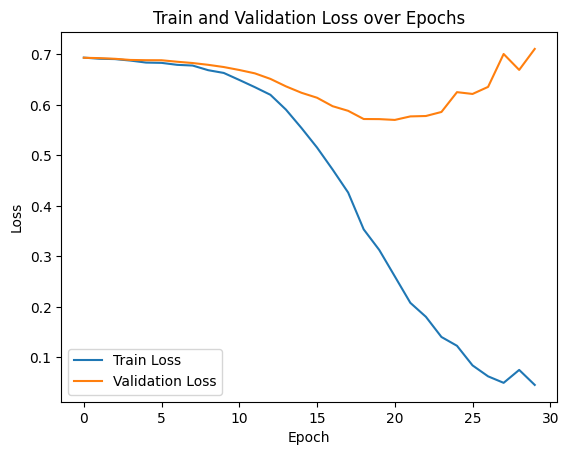

In [16]:
# Plotting the loss history
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

## Umap

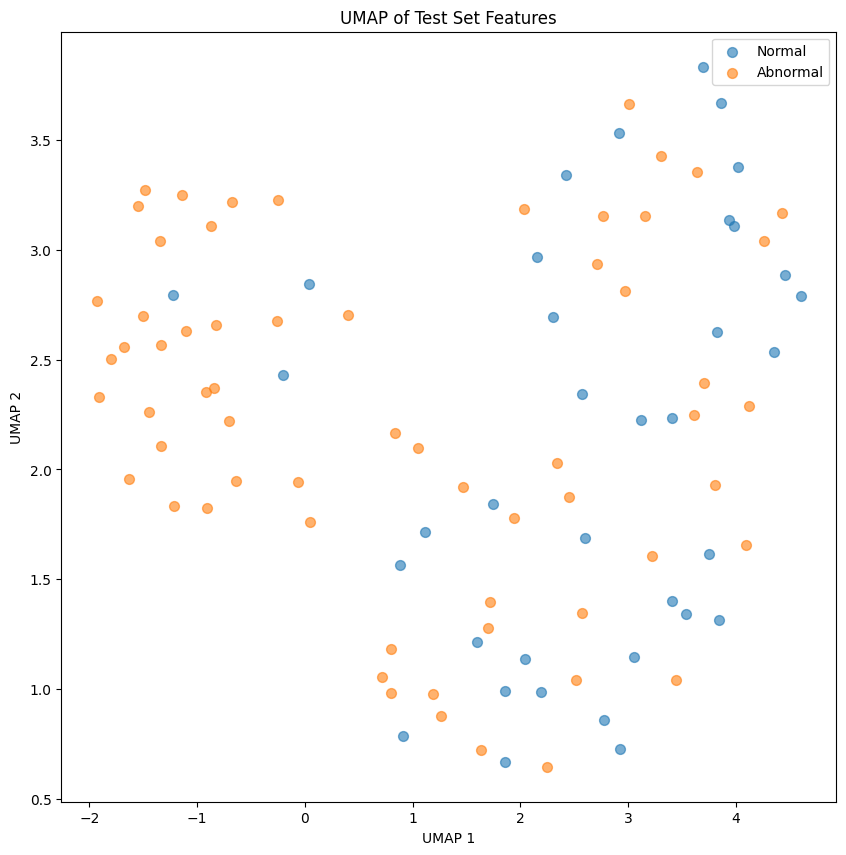

In [17]:
import umap
import torch.nn.functional as F

# Extract features from the last convolutional layer
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            outputs = model.resnet(inputs)  # Extract features from the ResNet

            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())

    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

# Extract features from the test set
features, labels = extract_features(model, dataloaders['test'])

# Apply UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_embeddings = umap_model.fit_transform(features)

# Plot UMAP
plt.figure(figsize=(10, 10))
unique_labels = np.unique(labels)
for label in unique_labels:
    indices = np.where(labels == label)[0]
    label_name = 'Normal' if label == 0 else 'Abnormal'
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=label_name, s=50, alpha=0.6)
plt.legend()
plt.title('UMAP of Test Set Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## Confusion matrix

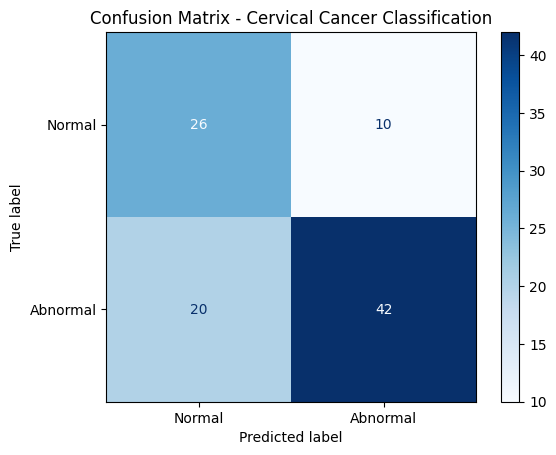

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Cervical Cancer Classification')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, dataloaders['test'])

## GradCAM

In [19]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x):
        b, c, h, w = x.size()
        output = self.model(x)
        if isinstance(output, (tuple, list)):
            output = output[0]
        self.model.zero_grad()
        output.sum().backward(retain_graph=True)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(c):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

def apply_gradcam(model, input_tensor, target_layer):
    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam(input_tensor)
    return heatmap

### Run this if there's at least 16 misclassified images

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


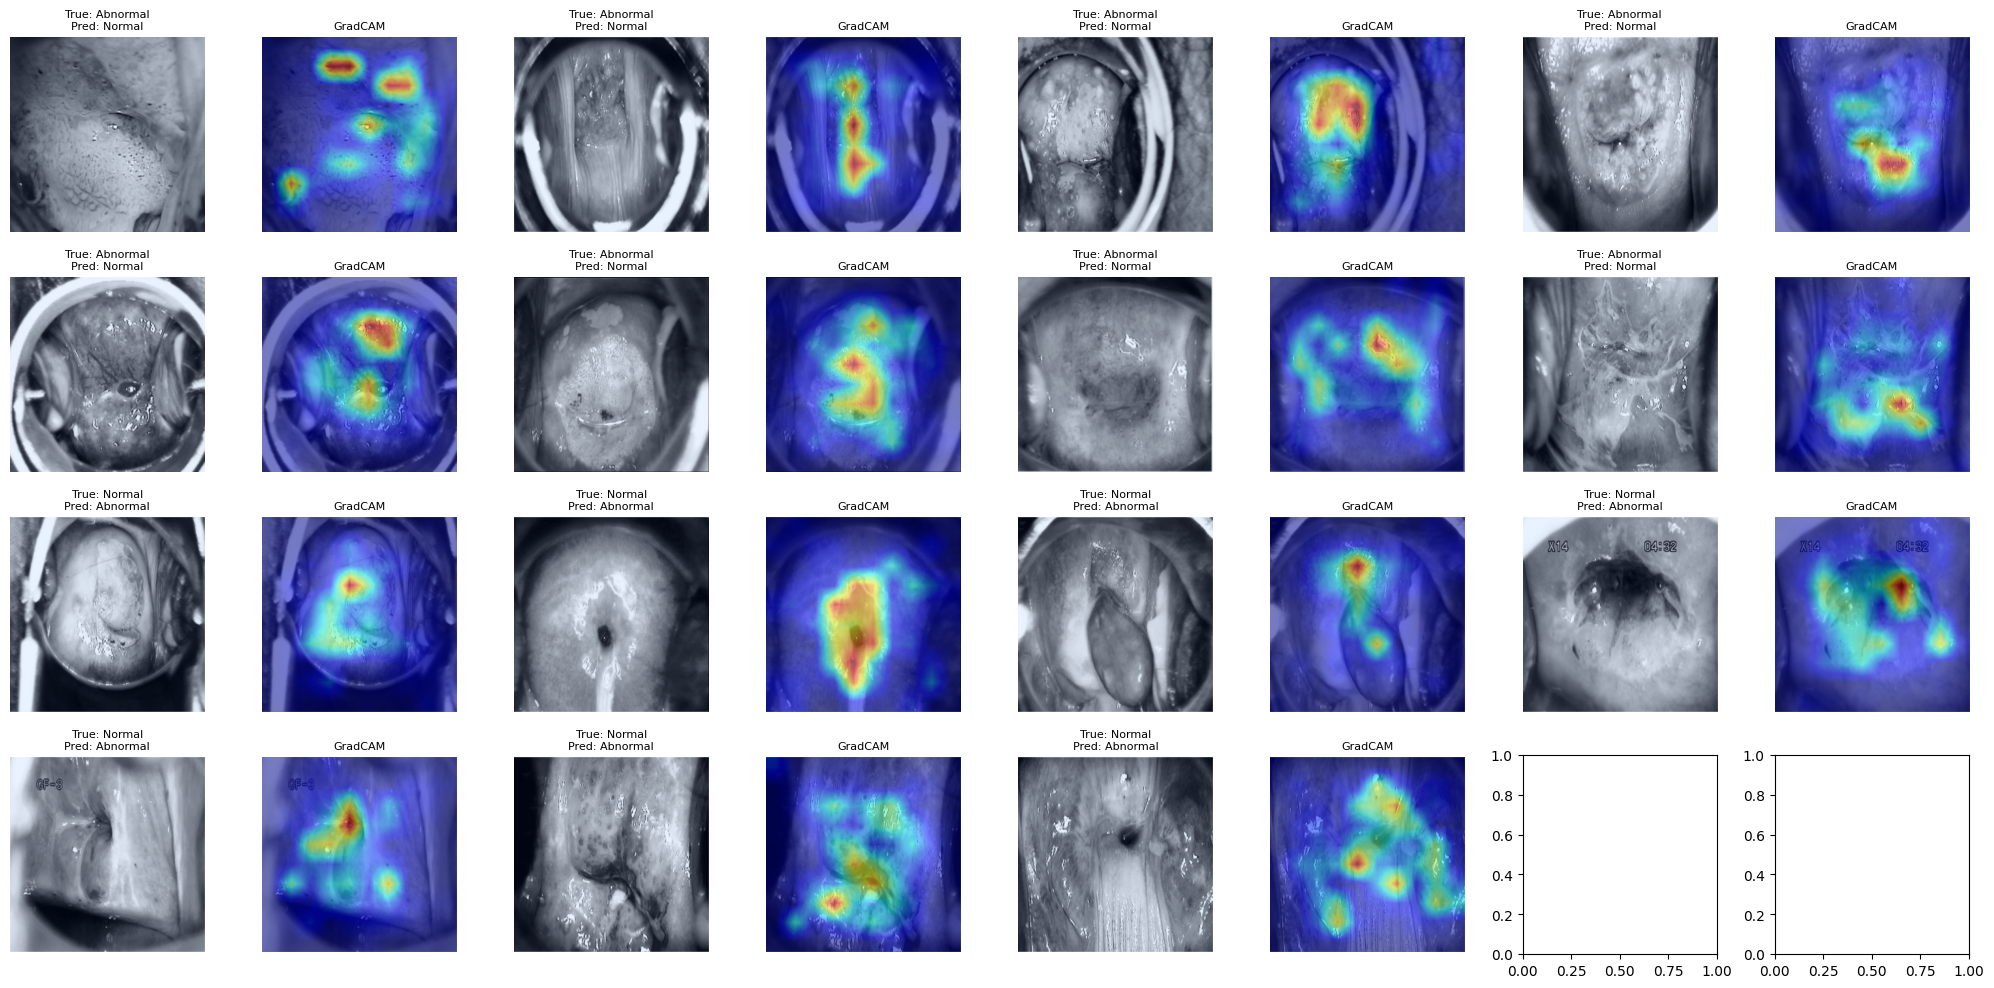

In [20]:
from collections import defaultdict
import itertools

def plot_misclassified_images_with_gradcam(model, dataloader, target_layer, num_images=16, grid_size=(4, 8), figsize=(20, 10)):
    """Plot misclassified images with their GradCAM visualizations"""
    misclassified_images = defaultdict(list)
    model.eval()

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                true_label = 'Normal' if labels[i].item() == 0 else 'Abnormal'
                pred_label = 'Normal' if preds[i].item() == 0 else 'Abnormal'
                mistake_key = (true_label, pred_label)
                misclassified_images[mistake_key].append((images[i], true_label, pred_label))

        if sum(len(v) for v in misclassified_images.values()) >= num_images:
            break

    if sum(len(v) for v in misclassified_images.values()) == 0:
        print("No misclassified images found.")
        return

    # Collect images to plot
    images_to_plot = []
    for mistake_type in sorted(misclassified_images.keys()):
        images_to_plot.extend(misclassified_images[mistake_type][:num_images//2])
        if len(images_to_plot) >= num_images:
            break
    images_to_plot = images_to_plot[:num_images]

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)

    for i, (input_image, true_label, pred_label) in enumerate(images_to_plot):
        input_image = input_image.unsqueeze(0)
        gradcam = apply_gradcam(model, input_image, target_layer)

        input_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min() + 1e-5)

        row = i // (grid_size[1] // 2)
        col = 2 * (i % (grid_size[1] // 2))

        axes[row, col].imshow(input_np)
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=8)
        axes[row, col].axis('off')

        axes[row, col + 1].imshow(input_np)
        axes[row, col + 1].imshow(cv.resize(gradcam, (input_np.shape[1], input_np.shape[0])), cmap='jet', alpha=0.5)
        axes[row, col + 1].set_title(f'GradCAM', fontsize=8)
        axes[row, col + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Get the target layer (last convolutional layer of ResNet)
target_layer = model.resnet.layer4[-1]

# Plot misclassified images with their GradCAMs
plot_misclassified_images_with_gradcam(model, dataloaders['test'], target_layer, num_images=16, grid_size=(4, 8))

### Run this if there's less than 16 misclassified images

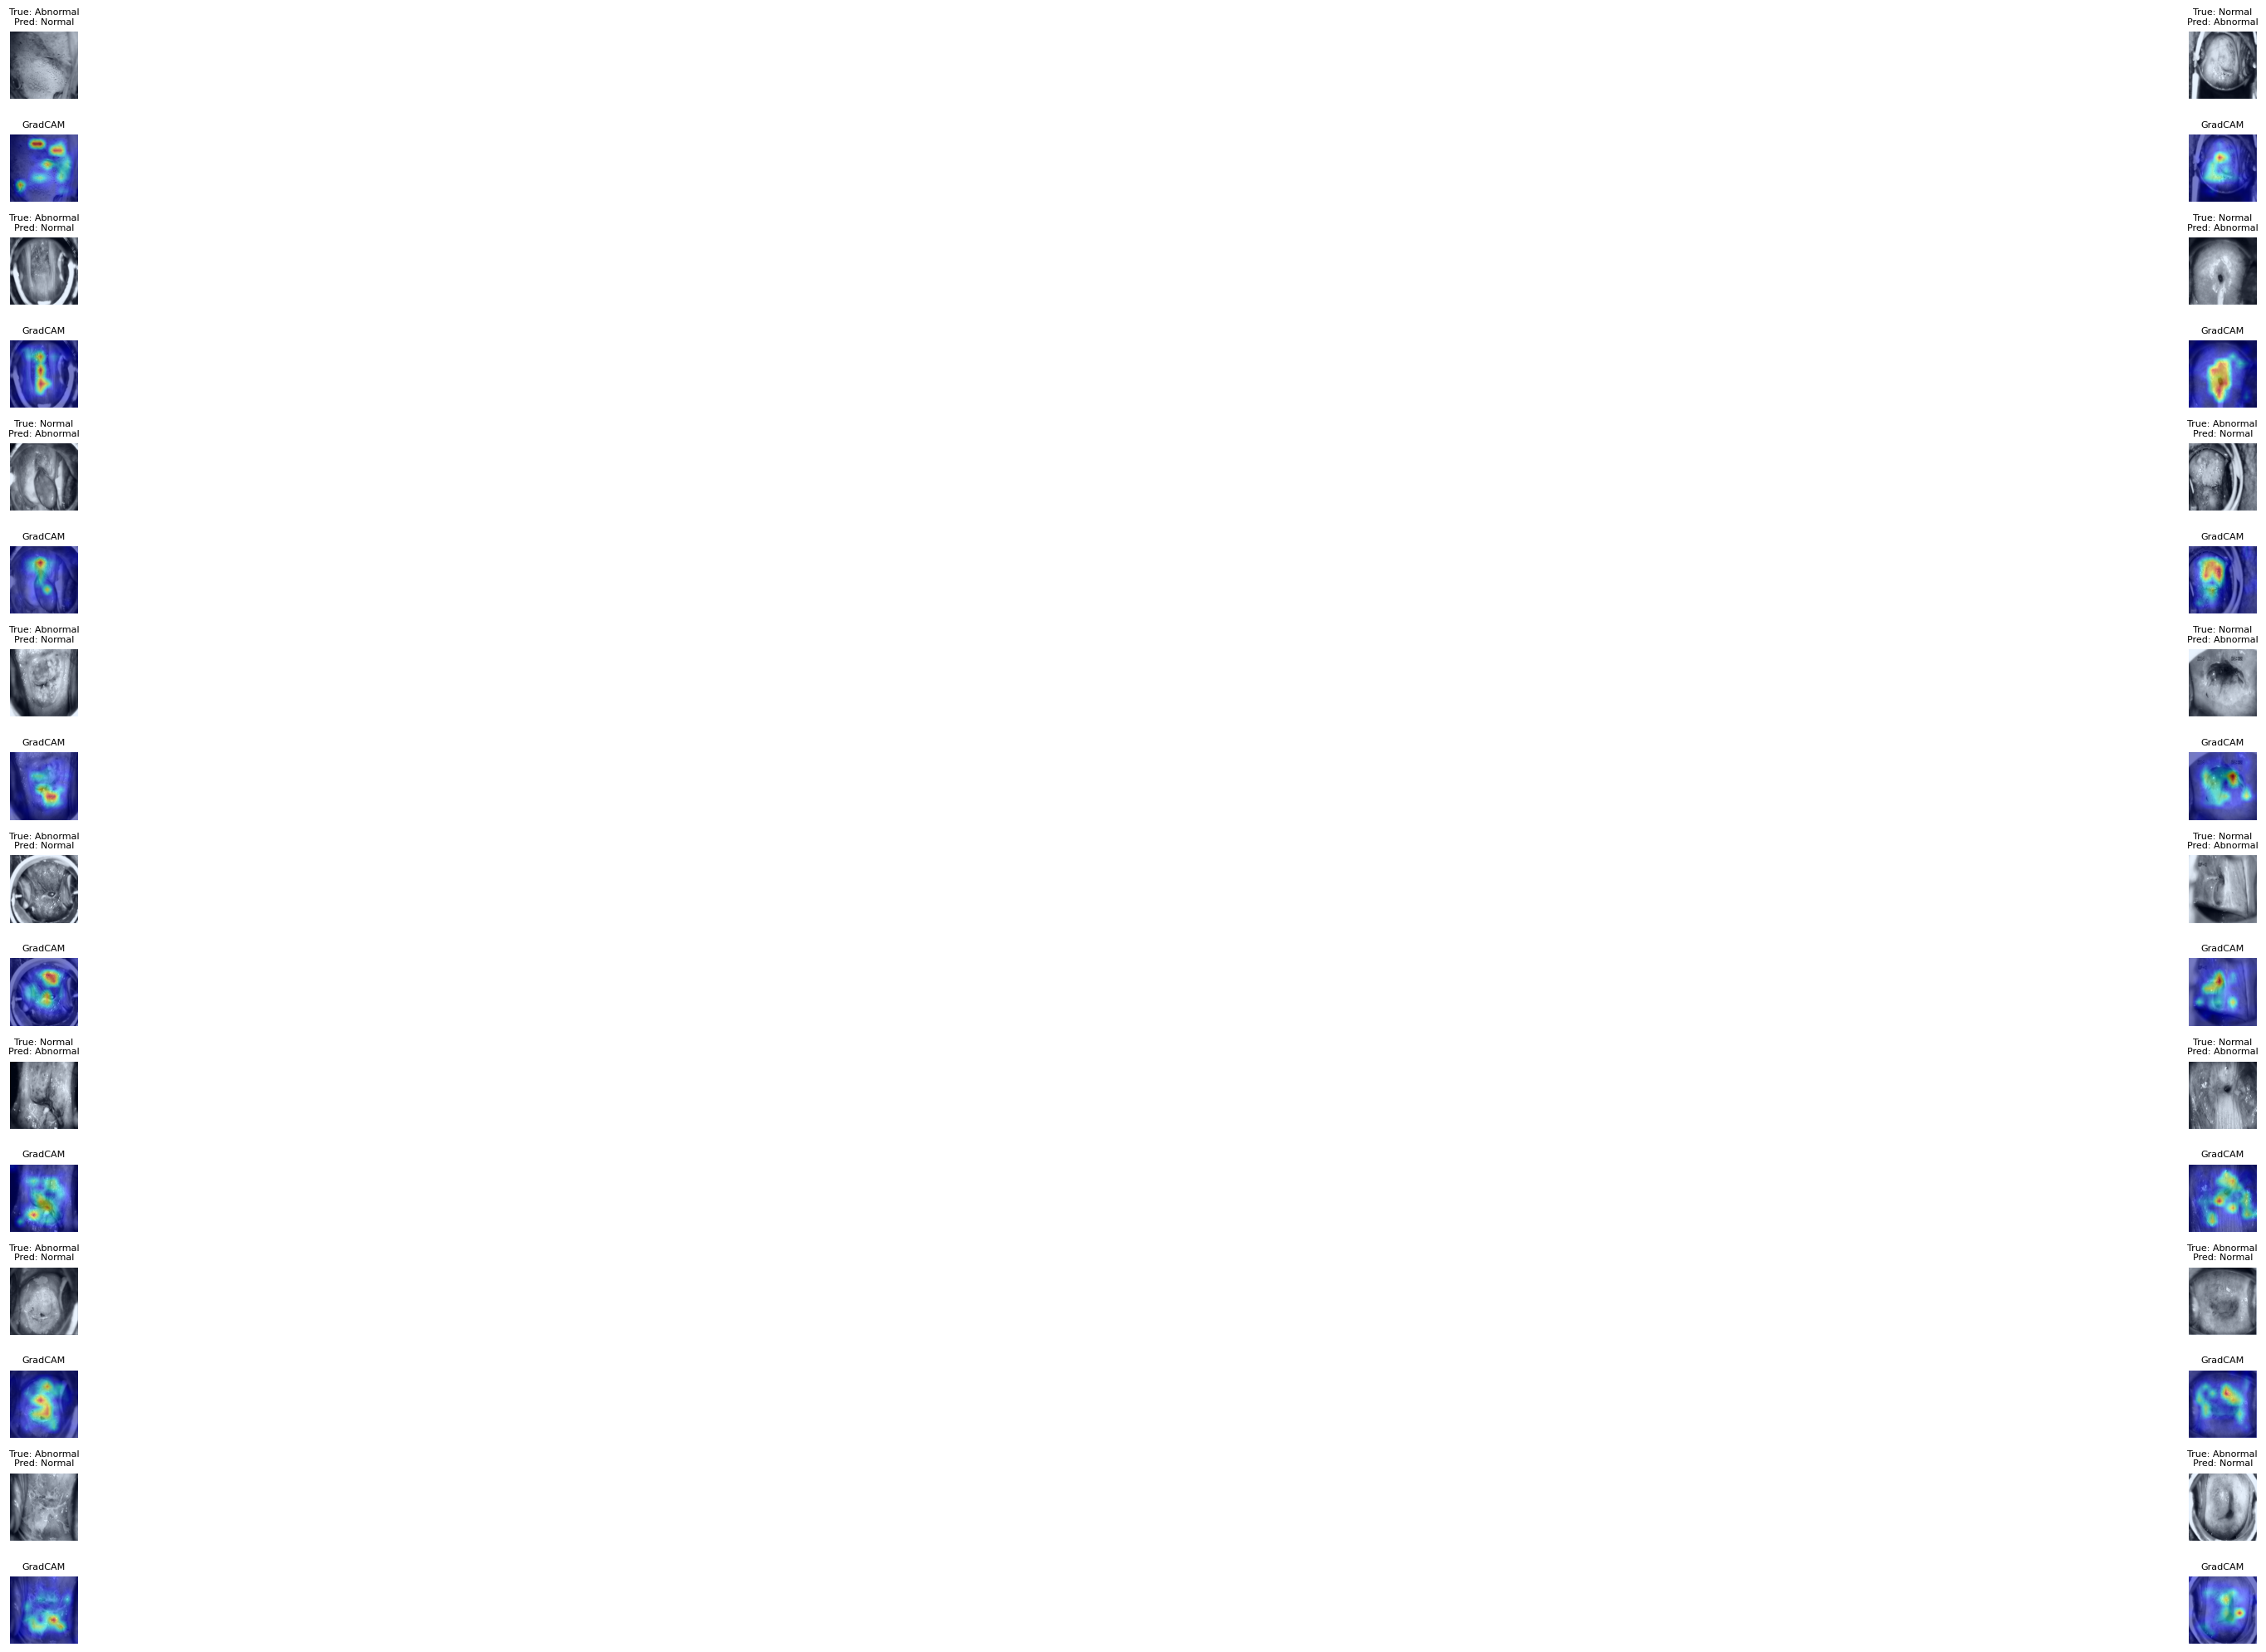

In [21]:
def plot_misclassified_images_with_gradcam_flex(model, dataloader, target_layer, num_images=16, figsize=(20, 20), max_batches=50, vertical=False):
    """Plot misclassified images with flexible layout"""
    misclassified_images = []
    model.eval()

    for batch_idx, (images, labels) in enumerate(dataloader):
        if batch_idx >= max_batches or len(misclassified_images) >= num_images:
            break

        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                true_label = 'Normal' if labels[i].item() == 0 else 'Abnormal'
                pred_label = 'Normal' if preds[i].item() == 0 else 'Abnormal'
                misclassified_images.append((images[i], true_label, pred_label))
                if len(misclassified_images) >= num_images:
                    break

    num_found = len(misclassified_images)
    if num_found == 0:
        print("No misclassified images found.")
        return

    # Calculate grid size based on the number of misclassified images and layout preference
    if vertical:
        grid_size = (num_found, 2)
        figsize = (figsize[0], figsize[1] * num_found / 4)
    else:
        grid_size = (2 * ((num_found + 1) // 2), 2)
        figsize = (figsize[0] * num_found / 4, figsize[1])

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.reshape(grid_size)

    for i, (input_image, true_label, pred_label) in enumerate(misclassified_images):
        input_image = input_image.unsqueeze(0)
        gradcam = apply_gradcam(model, input_image, target_layer)

        input_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min() + 1e-5)

        if vertical:
            row, col = i, 0
        else:
            row, col = (i // 2) * 2, i % 2

        axes[row, col].imshow(input_np)
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=8)
        axes[row, col].axis('off')

        if vertical:
            row, col = i, 1
        else:
            row, col = (i // 2) * 2 + 1, i % 2

        axes[row, col].imshow(input_np)
        axes[row, col].imshow(cv.resize(gradcam, (input_np.shape[1], input_np.shape[0])), cmap='jet', alpha=0.5)
        axes[row, col].set_title(f'GradCAM', fontsize=8)
        axes[row, col].axis('off')

    # Remove unused subplots
    for idx in range(num_found, grid_size[0]):
        if idx < len(axes):
            for col in range(grid_size[1]):
                if axes[idx, col] is not None:
                    fig.delaxes(axes[idx, col])

    plt.tight_layout()
    plt.show()

# Usage - for horizontal layout
target_layer = model.resnet.layer4[-1]
plot_misclassified_images_with_gradcam_flex(model, dataloaders['test'], target_layer, num_images=16, max_batches=50, vertical=False)

## Correctly classified images

In [22]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def get_probs_labels(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def threshold_for_target_recall(probs, labels, target_recall=0.90, max_fpr=0.50):
    precision, recall, thresholds = precision_recall_curve(labels, probs)
    best_thr = 0.5
    best_spec = -1.0
    if len(thresholds) == 0:
        return best_thr
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0, 1]).ravel()
        rec = tp / (tp + fn + 1e-8)
        fpr = fp / (fp + tn + 1e-8)
        spec = tn / (tn + fp + 1e-8)
        if rec >= target_recall and fpr <= max_fpr and spec > best_spec:
            best_spec = spec
            best_thr = float(thr)
    return best_thr

# Tune threshold on validation set to keep FN low
val_probs, val_labels = get_probs_labels(model, dataloaders['val'])
TARGET_RECALL = 0.90
MAX_FPR = 0.50
best_threshold = threshold_for_target_recall(val_probs, val_labels, target_recall=TARGET_RECALL, max_fpr=MAX_FPR)
print(f'Chosen threshold on val (target recall {TARGET_RECALL:.2f}, FPR<= {MAX_FPR:.2f}): {best_threshold:.3f}')

# Evaluate on test set
test_probs, test_labels = get_probs_labels(model, dataloaders['test'])
test_preds = (test_probs >= best_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(test_labels, test_preds, labels=[0, 1]).ravel()

accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, zero_division=0)
recall = recall_score(test_labels, test_preds, zero_division=0)
f1 = f1_score(test_labels, test_preds, zero_division=0)
try:
    auc = roc_auc_score(test_labels, test_probs)
except Exception:
    auc = float('nan')
specificity = tn / (tn + fp + 1e-8)

print('Confusion Matrix (labels: Normal=0, Abnormal=1)')
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall/Sensitivity: {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1: {f1:.4f}')
print(f'ROC-AUC: {auc:.4f}')


Chosen threshold on val (target recall 0.90, FPR<= 0.50): 0.500
Confusion Matrix (labels: Normal=0, Abnormal=1)
TN: 26, FP: 10, FN: 20, TP: 42
Accuracy: 0.6939
Precision: 0.8077
Recall/Sensitivity: 0.6774
Specificity: 0.7222
F1: 0.7368
ROC-AUC: 0.7545


Processing images for correctly classified samples...

Processing complete. Summary:
  Normal: 5/6 correct
  Abnormal: 8/10 correct
Plotting Normal class with 5 images


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Plotting Abnormal class with 5 images


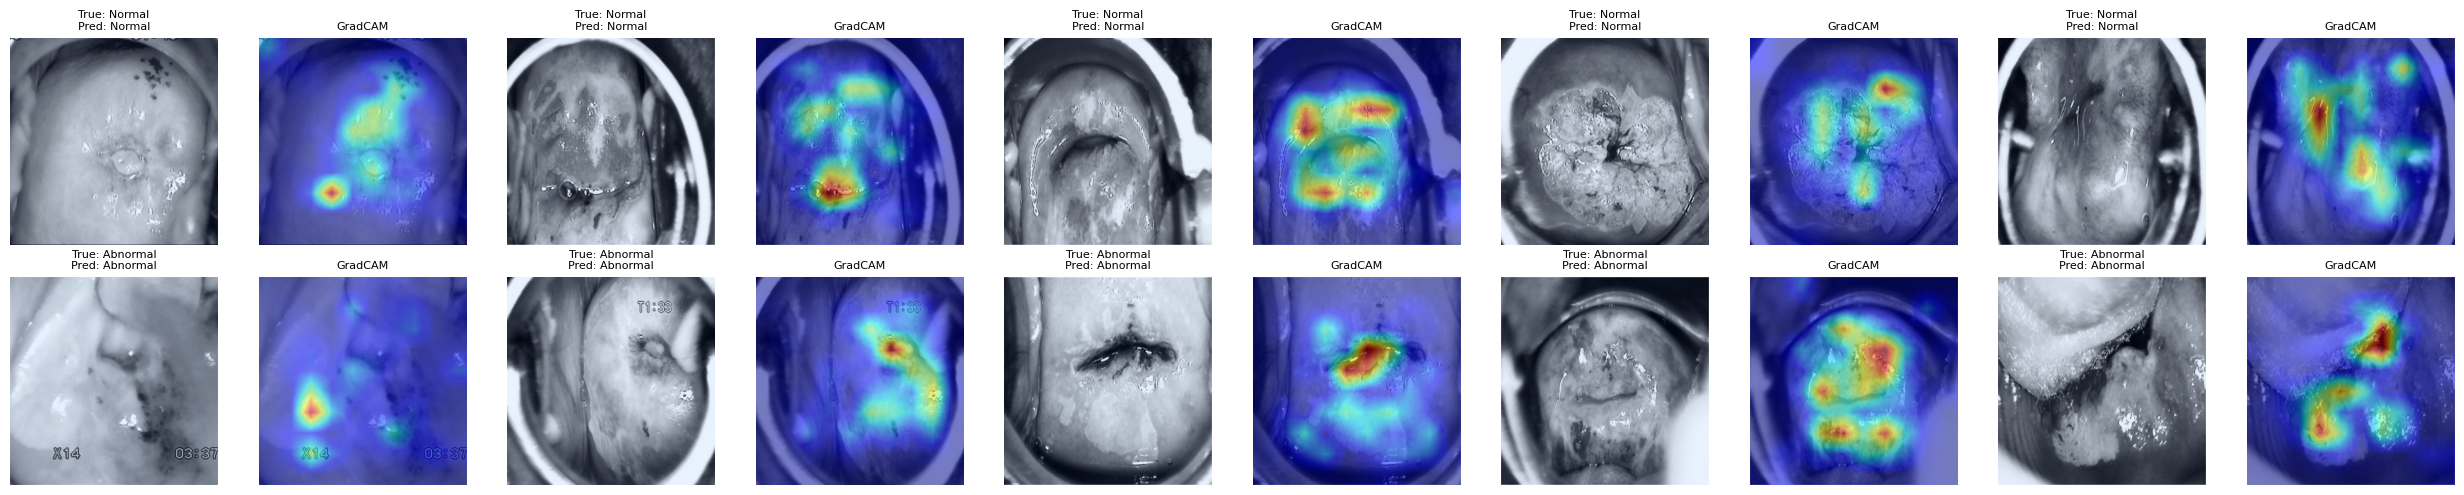

In [23]:
from collections import defaultdict

def plot_correctly_classified_images_with_gradcam(model, dataloader, target_layer, num_images_per_class=5, num_classes=2):
    """Plot correctly classified images with GradCAM visualizations"""
    correctly_classified_images = defaultdict(list)
    model.eval()

    total_correct = defaultdict(int)
    total_per_class = defaultdict(int)

    print("Processing images for correctly classified samples...")

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_label = preds[i].item()

            total_per_class[true_label] += 1

            if pred_label == true_label:
                total_correct[true_label] += 1
                if len(correctly_classified_images[true_label]) < num_images_per_class:
                    correctly_classified_images[true_label].append((images[i], true_label, pred_label))

        if all(len(v) >= num_images_per_class for k, v in correctly_classified_images.items()):
            break

    print("\nProcessing complete. Summary:")
    for cls in range(num_classes):
        total = total_per_class.get(cls, 0)
        correct = total_correct.get(cls, 0)
        class_name = 'Normal' if cls == 0 else 'Abnormal'
        print(f"  {class_name}: {correct}/{total} correct")

    # Filter out classes with no correct classifications
    classes_with_correct = [cls for cls in range(num_classes) if correctly_classified_images[cls]]
    num_classes_with_correct = len(classes_with_correct)

    if num_classes_with_correct == 0:
        print("No correctly classified images found for any class.")
        return

    # Adjust figure size based on number of classes with correct classifications
    figsize = (25, 2.5 * num_classes_with_correct)
    fig, axes = plt.subplots(num_classes_with_correct, 2 * num_images_per_class, figsize=figsize)

    # Ensure axes is always 2D
    if num_classes_with_correct == 1:
        axes = axes.reshape(1, -1)

    for idx, class_label in enumerate(classes_with_correct):
        images_for_class = correctly_classified_images[class_label]
        class_name = 'Normal' if class_label == 0 else 'Abnormal'
        print(f"Plotting {class_name} class with {len(images_for_class)} images")

        for i, (input_image, true_label, pred_label) in enumerate(images_for_class[:num_images_per_class]):
            input_image = input_image.unsqueeze(0)
            gradcam = apply_gradcam(model, input_image, target_layer)

            input_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
            input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min() + 1e-5)

            col = 2 * i

            axes[idx, col].imshow(input_np)
            true_name = 'Normal' if true_label == 0 else 'Abnormal'
            pred_name = 'Normal' if pred_label == 0 else 'Abnormal'
            axes[idx, col].set_title(f'True: {true_name}\nPred: {pred_name}', fontsize=8)
            axes[idx, col].axis('off')

            axes[idx, col + 1].imshow(input_np)
            axes[idx, col + 1].imshow(cv.resize(gradcam, (input_np.shape[1], input_np.shape[0])), cmap='jet', alpha=0.5)
            axes[idx, col + 1].set_title(f'GradCAM', fontsize=8)
            axes[idx, col + 1].axis('off')

        # Fill remaining slots with blank plots if necessary
        for i in range(len(images_for_class[:num_images_per_class]), num_images_per_class):
            col = 2 * i
            axes[idx, col].axis('off')
            axes[idx, col + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Get the target layer (last convolutional layer of ResNet)
target_layer = model.resnet.layer4[-1]

# Plot correctly classified images with their GradCAMs
plot_correctly_classified_images_with_gradcam(model, dataloaders['test'], target_layer, num_images_per_class=5, num_classes=2)

In [26]:
# save weights
torch.save(model.state_dict(), "/content/drive/MyDrive/cerviscreen/cervix_resnet50.pth")

# save config
import json
export_cfg = {
    "threshold": float(best_threshold),
    "input_size": 299,
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std": [0.229, 0.224, 0.225],
    "model_arch": "resnet50_custom",
}
with open("/content/drive/MyDrive/cerviscreen/cervix_export_config.json", "w") as f:
    json.dump(export_cfg, f, indent=2)


FileNotFoundError: Cannot find file: cervix_resnet50.pth